<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Все-функции" data-toc-modified-id="Все-функции-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Все функции</a></span><ul class="toc-item"><li><span><a href="#Функции-умножения-матрицы-на-транспонированную-и-различных-нормализаций" data-toc-modified-id="Функции-умножения-матрицы-на-транспонированную-и-различных-нормализаций-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Функции умножения матрицы на транспонированную и различных нормализаций</a></span></li><li><span><a href="#Функции-warp" data-toc-modified-id="Функции-warp-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Функции warp</a></span></li></ul></li><li><span><a href="#Использование-функции-warp" data-toc-modified-id="Использование-функции-warp-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Использование функции warp</a></span></li><li><span><a href="#Для-ускорения-вместо-интерполяции-выбор-максимально-близкого-пикселя" data-toc-modified-id="Для-ускорения-вместо-интерполяции-выбор-максимально-близкого-пикселя-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Для ускорения вместо интерполяции выбор максимально близкого пикселя</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, img_as_float
# img_as_float переводит имзображение в численное представление
# https://chat.openai.com/share/79755115-6b91-416e-ab70-b069c432674a


# м.б. потом убрать, поскольку для показа используем imshow
from IPython.display import display, Image
import cv2

# Все функции

## Функции умножения матрицы на транспонированную и различных нормализаций
Вдруг понадобятся ;-) 

In [2]:
def normalize_image(im):   
    im_res = im - np.min(im)
    return (1 / np.max(im_res)) * im_res

def norm_columns(x):
    columns_sums = np.sum(x, axis=0)
    columns_sums[columns_sums == 0] = np.finfo(float).eps
    # Убедимся, что нормализация применяется корректно
    return x / columns_sums[np.newaxis, :]

# поправила norm_rows, а то там появляется деление на ноль
def norm_rows(x):
    row_sums = np.sum(x, axis=1)
    # Замена нулей на очень маленькое число, чтобы избежать деления на ноль
    row_sums[row_sums == 0] = np.finfo(float).eps
    return x / row_sums[:, np.newaxis]

def monochrome(rgb_image):
    coeffs = np.array([0.299, 0.587, 0.114]) #!!! Не переводим элементы вектора в формат unit8
    return rgb_image @ coeffs

In [3]:


def trans_mult(A):
    result = normalize_image(np.dot(monochrome(A), np.transpose(monochrome(A))))
    return result

def trans_mult_norm(A):
    result = normalize_image(np.dot(norm_rows(monochrome(A)), norm_columns(np.transpose(monochrome(A)))))
    return result

def trans_mult_norm_plus_1(A):
    B = A+1
    result = normalize_image(np.dot(norm_rows(monochrome(B)), norm_columns(np.transpose(monochrome(B)))))
    return result

def normalize_image_signed(img):
    img1 = img - np.min(img)
    img2 = (2 / np.max(img1)) * img1
    return img2 - 1


def trans_mult_signed(A):
    B = normalize_image_signed(monochrome(A))
    result = normalize_image(np.dot(B, np.transpose(B)))
    return result

## Функции warp

In [4]:
import numpy as np

def warp_horizontal(x, y, knob, xsize):
    # Функция clip для ограничения значения n в пределах от 1 до nsize
    def clip(n, nsize):
        return max(min(nsize, n), 1)
    
    # Вычисление новой координаты x с учетом knob
    xnew = clip(x + 10 * ((knob - 16) / 16) * np.sin(y / 4), xsize)
    ynew = y
    return xnew, ynew

def apply_warp(warp, A, knob):
    [ysize, xsize] = A.shape # Получение размеров изображения
    
    def linear_interpolation(x_y, xsize, ysize):
        x, y = x_y
        dx = x % 1
        dy = y % 1
        x_left = int(np.floor(x))
        y_left = int(np.floor(y))
        x_right = min(x_left + 1, xsize-1)
        y_right = min(y_left + 1, ysize-1)
        # Вычисление значения нового пикселя через линейную интерполяцию
        return (A[y_left, x_left] * (1 - dx) * (1 - dy) + 
                A[y_right, x_left] * (1 - dx) * dy + 
                A[y_left, x_right] * dx * (1 - dy) + 
                A[y_right, x_right] * dx * dy)
    
    # Создание нового изображения с применением искажения и интерполяции
    result = np.zeros_like(A)
    for x in range(1, xsize + 1):
        for y in range(1, ysize + 1):
            new_x, new_y = warp(x, y, knob, xsize) # Передаем knob и xsize в функцию warp
            # Адаптация координат под нулевую индексацию и запись в result
            result[y - 1, x - 1] = linear_interpolation((new_x - 1, new_y - 1), xsize, ysize)
    
    return result


In [5]:
# сделаем рисование трех картинок только  одной функцией warp

def wrap_text(text, max_length):
   
    if len(text) <= max_length:
        return text
    # Находим пробел ближайший к середине строки для красивого переноса
    split_points = [i for i, char in enumerate(text) if char == ' ']
    best_split = min(split_points, key=lambda x: abs(x - max_length))
    return text[:best_split] + '\n' + wrap_text(text[best_split+1:], max_length)


def picture_warp (kind_warp, warp_name, knob, A, B, C, A_name, B_name, C_name):
   
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 14))
    plt.subplots_adjust(hspace=0.3)
    axes[0,0].imshow(monochrome(A), cmap='gray')
    axes[0,0].set_title(A_name)
# Включение сетки
    axes[0,0].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[0,1].imshow(monochrome(B), cmap='gray')
    axes[0,1].set_title(B_name)
# Включение сетки
    axes[0,1].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[0,2].imshow(monochrome(C), cmap='gray')
    axes[0,2].set_title(C_name)
# Включение сетки
    axes[0,2].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    fig.text(0.5, 0.5, f'Pictures after {warp_name}\n', 
         ha='center', va='center', fontsize=15)

    
    axes[1,0].imshow(apply_warp(kind_warp, monochrome(A), knob), cmap='gray')
    axes[1,0].set_title(wrap_text(f'{A_name} after \n{warp_name}', 45))
# Включение сетки
    axes[1,0].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)


    
    axes[1,1].imshow(apply_warp(kind_warp, monochrome(B), knob), cmap='gray')
    axes[1,1].set_title(wrap_text(f'{B_name} after \n{warp_name}', 45))
    axes[1,1].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[1,2].imshow(apply_warp(kind_warp, monochrome(C), knob), cmap='gray')
    axes[1,2].set_title(wrap_text(f'{C_name} after \n{warp_name}', 45))

    axes[1,2].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)
    
    # Отображение фигуры с подграфиками
    plt.show()



# Использование функции warp

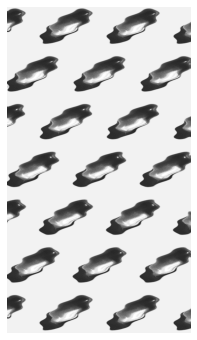

In [12]:
# Быстрая проверка на одной картинке
# оставляем, потому что рисование трех картинок это долго
yellow_raw = io.imread('https://images.unsplash.com/photo-1623066542605-bc25b4b662dd?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3'
                   '&ixid=M3wxMjA3fDB8MHx0b3BpYy1mZWVkfDI4fGlVSXNuVnRqQjBZfHxlbnwwfHx8fHw%3D')

def monochrome(rgb_image):
    coeffs = np.array([0.299, 0.587, 0.114]) #!!! Не переводим элементы вектора в формат unit8
    return rgb_image @ coeffs

yellow = monochrome(yellow_raw)

knob = 24
plt.figure(figsize=(12, 6))
plt.imshow(apply_warp(warp_horizontal, yellow, knob), cmap = 'gray')
plt.axis('off')
plt.show()

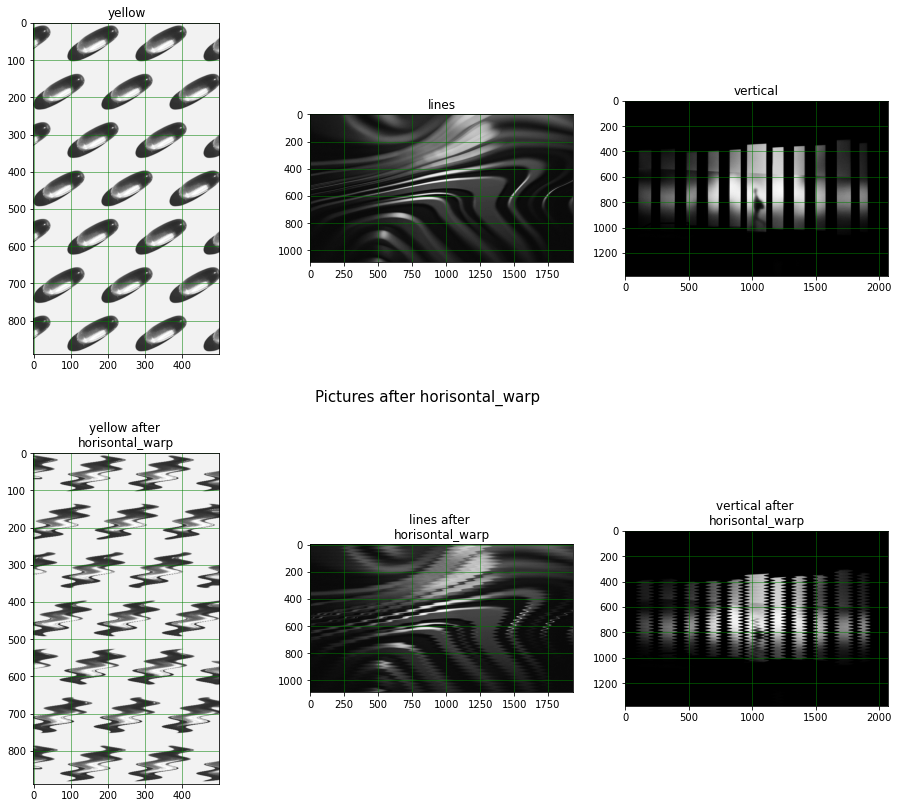

In [7]:
# синтаксис вот такой picture_warp (kind_warp, warp_name, knob, A, B, C, A_name, B_name, C_name)
yellow = io.imread('https://images.unsplash.com/photo-1623066542605-bc25b4b662dd?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3'
                   '&ixid=M3wxMjA3fDB8MHx0b3BpYy1mZWVkfDI4fGlVSXNuVnRqQjBZfHxlbnwwfHx8fHw%3D')
lines = io.imread('https://images.unsplash.com/photo-1704520355609-c62b0c4010df?q=80&w=1932&auto=format'
                  '&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')
vertical = io.imread('https://images.unsplash.com/photo-1499428665502-503f6c608263?q=80&w=2070&auto=format&fit=crop&ixlib'
                         '=rb-4.0.3,&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

picture_warp (warp_horizontal, 'horisontal_warp', 50, yellow, lines, vertical, 'yellow', 'lines', 'vertical')

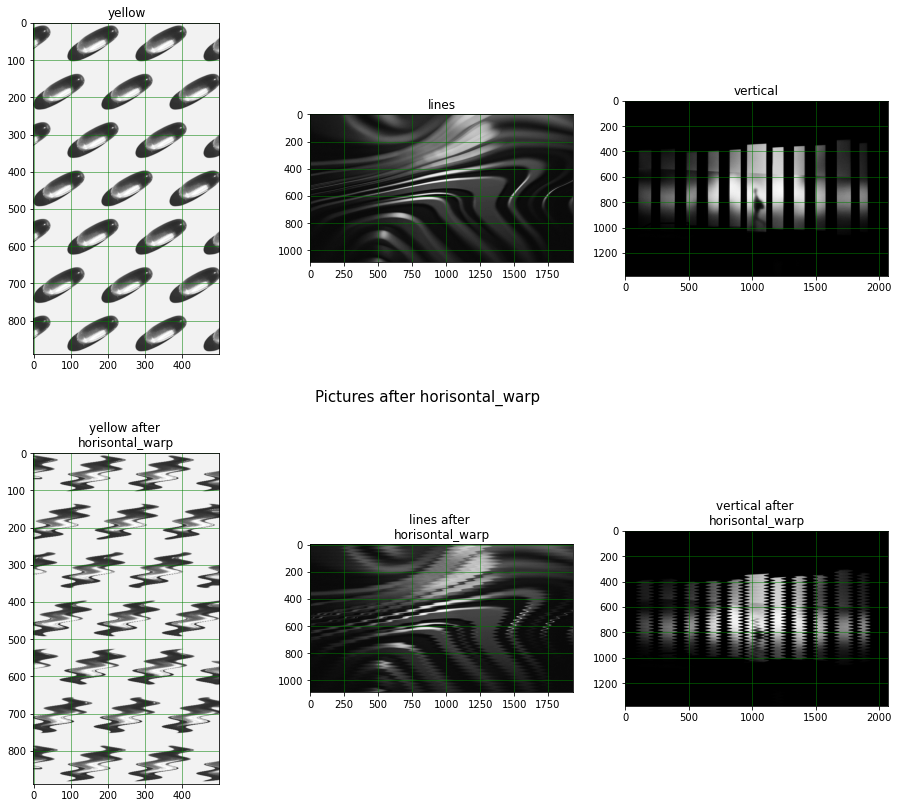

In [8]:
# Можно использовать немного другой синтаксис
# синтаксис вот такой picture_warp (kind_warp=, warp_name=, knob=, A=, B=, C=, A_name=, B_name=, C_name=)
picture_warp (kind_warp = warp_horizontal, warp_name = 'horisontal_warp', knob=50, 
              A=yellow, B=lines, C=vertical, A_name = 'yellow', B_name = 'lines', C_name = 'vertical')

# Для ускорения вместо интерполяции выбор максимально близкого пикселя
Но не помогло :-( 

In [9]:
# это попробую без интерполяции, будет ли это быстрнее считать
def apply_quick_warp(warp, A, knob):
    [ysize, xsize] = A.shape # Получение размеров изображения
    
    # Функция для выбора максимально близкого пикселя через округление
    def nearest_pixel_interpolation(x_y, xsize, ysize):
        x, y = x_y
        x_rounded = int(round(x))
        y_rounded = int(round(y))
        # Ограничение координат в пределах допустимых значений
        x_rounded = max(min(x_rounded, xsize - 1), 0)
        y_rounded = max(min(y_rounded, ysize - 1), 0)
        return A[y_rounded, x_rounded]
    
    # Создание нового изображения с применением искажения и выбором ближайшего пикселя
    result = np.zeros_like(A)
    for x in range(1, xsize + 1):
        for y in range(1, ysize + 1):
            new_x, new_y = warp(x, y, knob, xsize) # Передаем knob и xsize в функцию warp
            # Адаптация координат под нулевую индексацию и запись в result
            result[y - 1, x - 1] = nearest_pixel_interpolation((new_x - 1, new_y - 1), xsize, ysize)
    
    return result

In [10]:
# сделаем рисование картинок на основе фуекции apply_quick_warp, где вместо интерполяции мы берем ближайшимй пиксель. 

def wrap_text(text, max_length):
   
    if len(text) <= max_length:
        return text
    # Находим пробел ближайший к середине строки для красивого переноса
    split_points = [i for i, char in enumerate(text) if char == ' ']
    best_split = min(split_points, key=lambda x: abs(x - max_length))
    return text[:best_split] + '\n' + wrap_text(text[best_split+1:], max_length)


def picture_quick_warp (kind_warp, warp_name, knob, A, B, C, A_name, B_name, C_name):
    def delta(A):
        return f_2(A) - f_1(A)
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 14))
    plt.subplots_adjust(hspace=0.3)
    axes[0,0].imshow(monochrome(A), cmap='gray')
    axes[0,0].set_title(A_name)
# Включение сетки
    axes[0,0].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[0,1].imshow(monochrome(B), cmap='gray')
    axes[0,1].set_title(B_name)
# Включение сетки
    axes[0,1].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[0,2].imshow(monochrome(C), cmap='gray')
    axes[0,2].set_title(C_name)
# Включение сетки
    axes[0,2].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    fig.text(0.5, 0.5, f'Pictures after {warp_name}\n', 
         ha='center', va='center', fontsize=15)

    
    axes[1,0].imshow(apply_quick_warp(kind_warp, monochrome(A), knob), cmap='gray')
    axes[1,0].set_title(wrap_text(f'{A_name} after \n{warp_name}', 45))
# Включение сетки
    axes[1,0].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)


    
    axes[1,1].imshow(apply_quick_warp(kind_warp, monochrome(B), knob), cmap='gray')
    axes[1,1].set_title(wrap_text(f'{B_name} after \n{warp_name}', 45))
    axes[1,1].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)

    axes[1,2].imshow(apply_quick_warp(kind_warp, monochrome(C), knob), cmap='gray')
    axes[1,2].set_title(wrap_text(f'{C_name} after \n{warp_name}', 45))

    axes[1,2].grid(True, which='both', color='green', linestyle='-', linewidth=0.5)
    
    # Отображение фигуры с подграфиками
    plt.show()



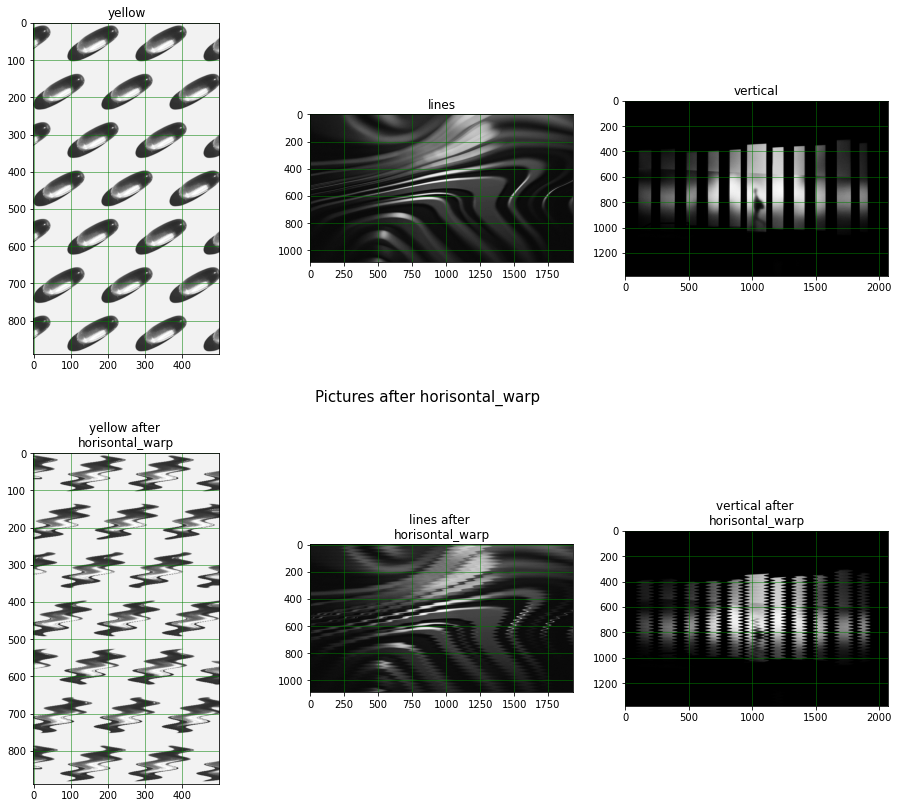

In [11]:
yellow = io.imread('https://images.unsplash.com/photo-1623066542605-bc25b4b662dd?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3'
                   '&ixid=M3wxMjA3fDB8MHx0b3BpYy1mZWVkfDI4fGlVSXNuVnRqQjBZfHxlbnwwfHx8fHw%3D')
lines = io.imread('https://images.unsplash.com/photo-1704520355609-c62b0c4010df?q=80&w=1932&auto=format'
                  '&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')
vertical = io.imread('https://images.unsplash.com/photo-1499428665502-503f6c608263?q=80&w=2070&auto=format&fit=crop&ixlib'
                         '=rb-4.0.3,&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D')

picture_quick_warp (warp_horizontal, 'horisontal_warp', 50, yellow, lines, vertical, 'yellow', 'lines', 'vertical')

Попытка ускорить расчеты, заменив интерполяцимю по соседним пикселям выбором ближайшего пикселя, не привела к успеху. Расчеты нефига не ускорились